In [224]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
from src.visualization.mapper import *
from src.features.landuse import *


import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Setup the Dataset

In [6]:
# start building dataset from scratch. Only have to do this once after adding more data
dataset = Dataset('Jakarta')
dataset.build_all_data( build_fire=False, build_holiday = False)

add US embassy data
Averaging data from 3 stations


In [70]:
# reinit the data and load saved process data 
dataset = Dataset('Jakarta')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

In [8]:
# pollution data is in attribute 
dataset.poll_df.head(2)

,PM2.5
datetime,
2015-11-20 20:00:00,36.0
2015-11-20 21:00:00,50.0


In [22]:
# fire data is in attribute fire
dataset.fire.head(2)

,latitude,longitude,confidence,lat_km,long_km,distance,power,count
datetime,,,,,,,,
2002-07-04 05:04:00,-8.1127,112.9357,27,-900,12572,710.073940,217.280,1
2002-07-04 05:04:00,-8.1091,112.9136,73,-900,12569,707.210011,366.912,1


In [23]:
# weather data is in attribute 
dataset.wea.head(2)

,Time,Temperature(C),Humidity(%),Wind,Wind Speed(kmph),Pressure(in),Precip.(in),Condition
datetime,,,,,,,,
2000-01-01 01:00:00,07:00 AM,25.0,94.0,SW,6.0,29.79577,0.0,Clouds
2000-01-01 01:30:00,07:00 AM,25.0,94.0,SW,6.0,29.79577,0.0,Clouds


In [24]:
# merge pollution data and weather is in 
dataset.data_no_fire.head(2)

,PM2.5,Temperature(C),Humidity(%),Wind Speed(kmph),wind_E,wind_N,wind_S,wind_W,is_rain,is_holiday,is_weekend,day_of_week,time_of_day
datetime,,,,,,,,,,,,,
2015-12-21 23:00:00,22.0,26.0,76.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0
2015-12-22 00:00:00,23.0,26.0,79.0,8.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


# Explore the Data

pollutants to plot Index(['PM2.5'], dtype='object')


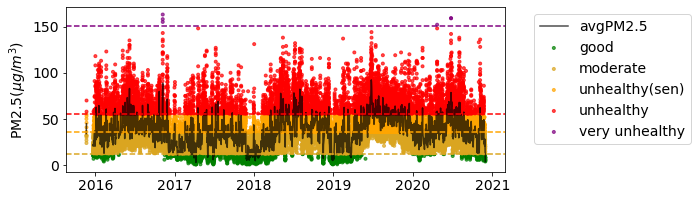

In [29]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)
#plt.ylim([0, 250])

PM2.5    174.166667
dtype: float64


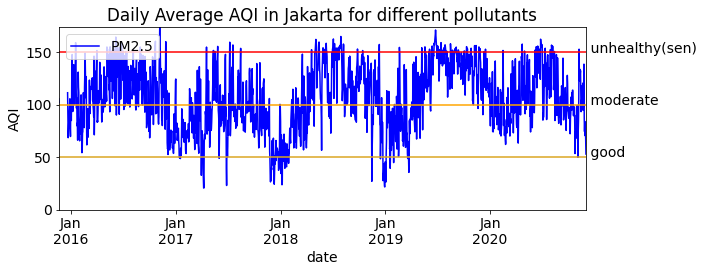

In [43]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

Text(0, 0.5, 'number of hotspots')

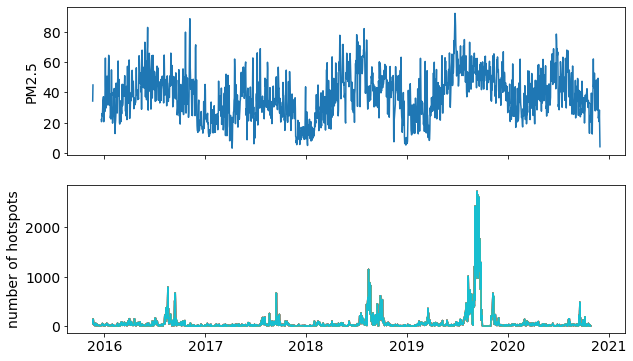

In [64]:
df = dataset.fire.resample('d').count().loc[dataset.poll_df.index.min(): dataset.poll_df.index.max()]
poll_d = dataset.poll_df.resample('d').mean()
_, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(poll_d)
ax[0].set_ylabel('PM2.5')

ax[1].plot(df)
ax[1].set_ylabel('number of hotspots')

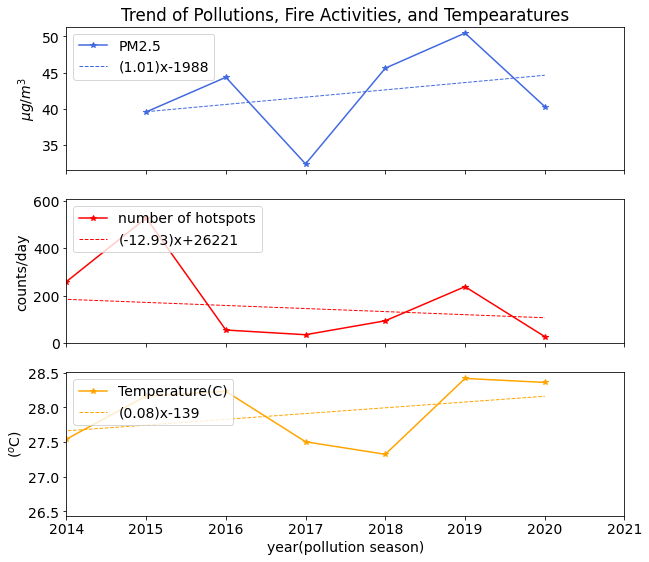

In [154]:
ax, year_avg = plot_yearly_ln(dataset, filename=dataset.report_folder + 'compare_ln_trends.png', start_month='-04-01', end_month='-12-01', next_year=False)

ax[-1].set_xlim([2014, 2021])

plt.savefig(dataset.report_folder + 'compare_ln_trends.png')

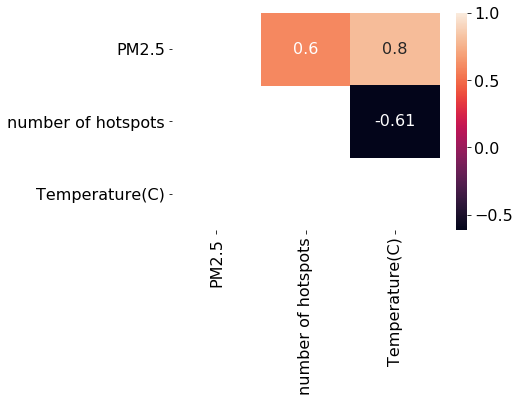

In [75]:
plot_corr(year_avg, figsize=(6,4))

aqi 100 in  01-06 to 12-31
aqi 150 in  07-13 to 07-19


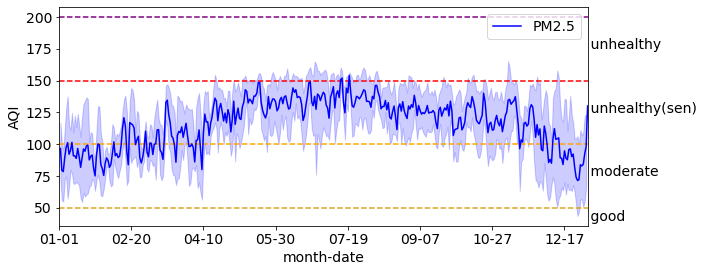

In [123]:
ax, winter_day_dict = plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png', offset=0)

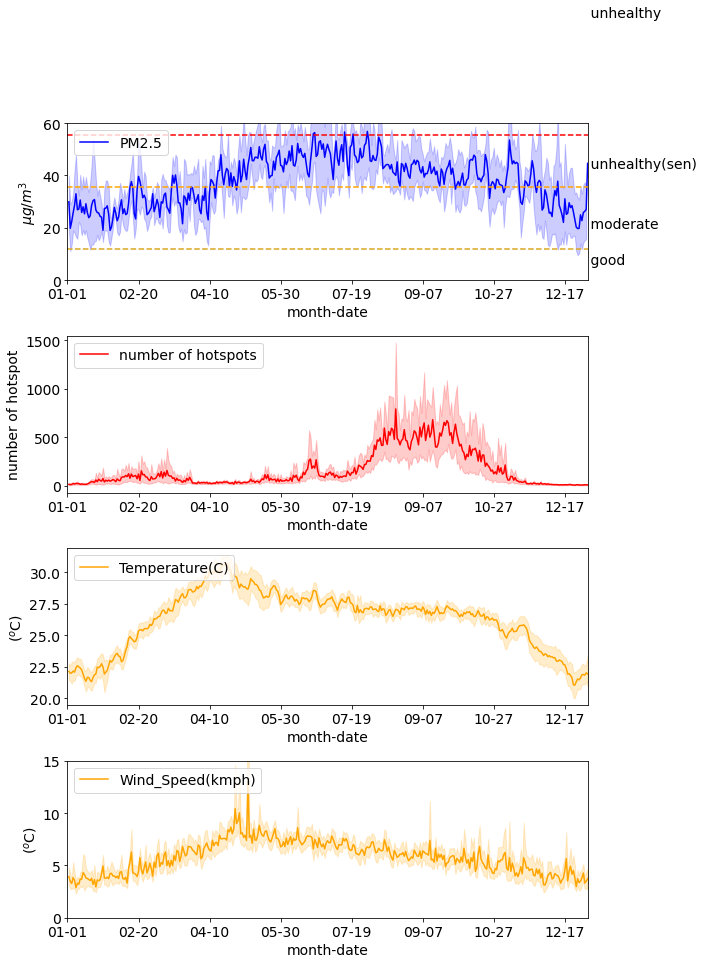

In [130]:
ax = compare_seson_avg(dataset, agg='mean', offset=0)
ax[0].set_ylim([0, 60])
ax[-1].set_ylim([0, 15])

plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

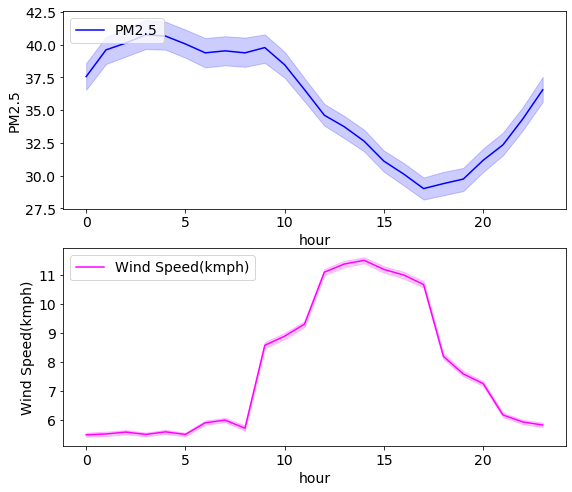

In [6]:
_, ax = plt.subplots(2, 1, figsize=(9, 8))
plot_hour_avg(dataset.poll_df, 'PM2.5', ax[0],  color='blue')
plot_hour_avg(dataset.wea, 'Wind Speed(kmph)',  ax[1],  color='magenta')

# Fire Zone

In [171]:
dataset = Dataset('Jakarta')
dataset.load_()
dataset.city_info

x = dataset.city_info['long_m']
y = dataset.city_info['lat_m']
#stepx = 2E5

stepx = 2E6
stepy = stepx

In [172]:
dataset.zone_list

[0, 100, 200, 400, 800, 1000]

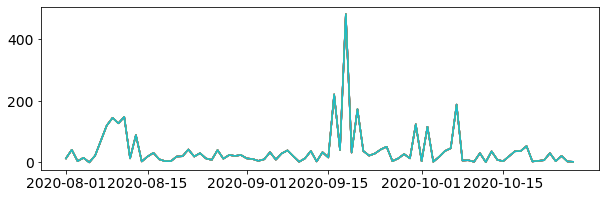

In [178]:
start_date = '2020-08-01'
end_date = '2020-10-30'
fire_m = dataset.fire.loc[start_date:end_date]
plt.figure(figsize=(10,3))
plt.plot(fire_m.resample('d').count());

In [179]:
start_date = '2020-09-01'
end_date = '2020-09-30'
fire_m = dataset.fire.loc[start_date:end_date]

In [180]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-0.5*stepx,x+0.5*stepx), y_range=(y-stepy*0.1, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))


#add circles
labels = ['0-100km','100-200km','200-400km','400-800km']

rs = [0, 100, 200, 400, 800, 1000] 
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)
    
# add city center
p.scatter(x,y,color='red',line_color='black',size=10, legend_label=dataset.city_name)

p.scatter(fire_m['long_km']*1000, fire_m['lat_km']*1000,color='red',size=2, alpha=0.5,legend_label='fire in September 2020')

    
p.legend.location = "bottom_right"
wmark_bokeh(p)

show(p)
export_png(p, filename=dataset.report_folder + "fire_zone.png")

'C:\\Users\\Benny\\Documents\\Fern\\aqi_thailand2\\reports\\jakarta\\fire_zone.png'

# Analyze Fire Activities

Add landuse label

In [196]:
dataset = Dataset('Jakarta')
label_landuse_fire('../data/jakarta/' + 'fire_m.csv')
fire = pd.read_csv('../data/jakarta/fire_m_label.csv')
fire = add_countries(fire, city_xy_m=[dataset.city_info['long_m'], dataset.city_info['lat_m']], filename='../data/jakarta/fire_m_label.csv')

In [201]:
fire = pd.read_csv('../data/jakarta/fire_m_label.csv')
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire = fire.set_index('datetime')
fire.head()

,latitude,longitude,distance,long_km,lat_km,LC_Prop2,LC_Prop2_label,LC_Type1,LC_Type1_label,LC_Type5,LC_Type5_label,label,country
datetime,,,,,,,,,,,,,
2002-07-04 05:04:00,-8.1118,112.9012,706.965007,12568.104094,-906.033311,20.0,forest,6.0,shrubland,6.0,shrubland,shrubland,Indonesia
2002-07-04 05:04:00,-8.1091,112.9136,708.190073,12569.484456,-905.729712,1.0,NaN,6.0,shrubland,6.0,shrubland,shrubland,Indonesia
2002-07-04 05:04:00,-8.1167,112.9303,710.220005,12571.343491,-906.584292,1.0,NaN,6.0,shrubland,6.0,shrubland,shrubland,Indonesia
2002-07-04 05:04:00,-8.1127,112.9357,710.658302,12571.944616,-906.134511,20.0,forest,6.0,shrubland,6.0,shrubland,shrubland,Indonesia
2002-07-04 10:04:00,1.6437,109.2867,917.180561,12165.739794,183.000950,10.0,forest,2.0,forest,2.0,forest,forest,Indonesia


In [202]:
# obtain the seasonal pattern of fire by country 
fire['count'] = 1
fire_country = pd.pivot_table(fire, values='count', columns='country',index=fire.index,aggfunc='sum').fillna(0).astype(int)
fire_country = fire_country.resample('d').sum()
fire_country_sea, winter_day_dict = season_avg(fire_country, cols=fire_country.columns.to_list(), roll=False, agg='sum', offset=0)
fire_country_sea = fire_country_sea.groupby('winter_day').mean()[fire_country.columns]

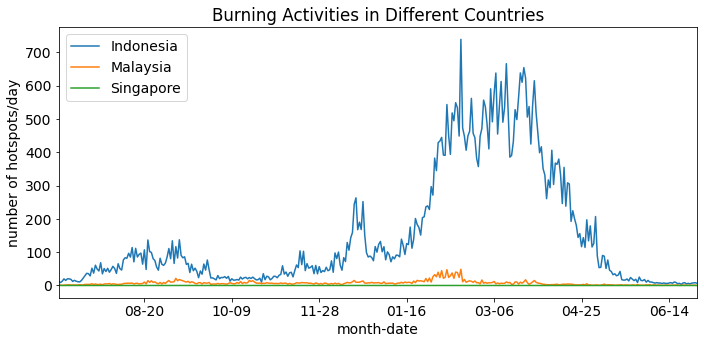

In [203]:
_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(fire_country_sea)
ax.legend(fire_country_sea.columns, loc='upper left')
ax.set_title('Burning Activities in Different Countries')
ax.set_xlim([fire_country_sea.index.min(), fire_country_sea.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')
plt.tight_layout()

plt.savefig(dataset.report_folder + 'hotspots_country.png')

## Landuse of the hotspots

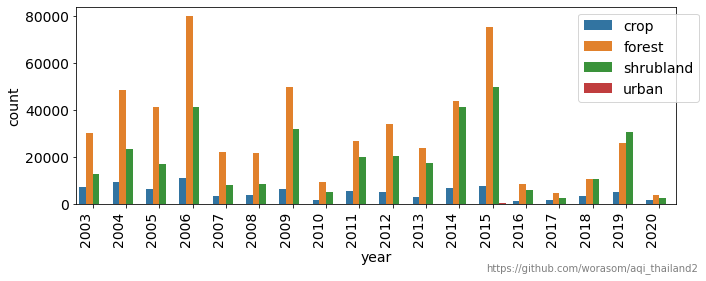

In [205]:
fire['count'] = 1
prop_type = 'label'
fire['year'] = fire.index.year
lc_count = fire.groupby(['year', prop_type], as_index=False)['count'].count()
lc_count = lc_count[~lc_count[prop_type].isin(['water', 'unclassified'])]
lc_count = lc_count[lc_count['year'] !=2002]

fig, ax = plt.subplots(1,1, figsize=(10, 4))
sns.barplot(x="year", y="count", hue=prop_type, data=lc_count, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right');
plt.tight_layout()
wmark_plt(fig)
plt.savefig(dataset.report_folder + 'landuse_all.png')

In [207]:
lc_count = fire.groupby(['year', 'country', prop_type], as_index=False)['count'].count()
lc_count = lc_count[~lc_count[prop_type].isin(['water', 'unclassified'])]
lc_count = lc_count[lc_count['year'] !=2002]

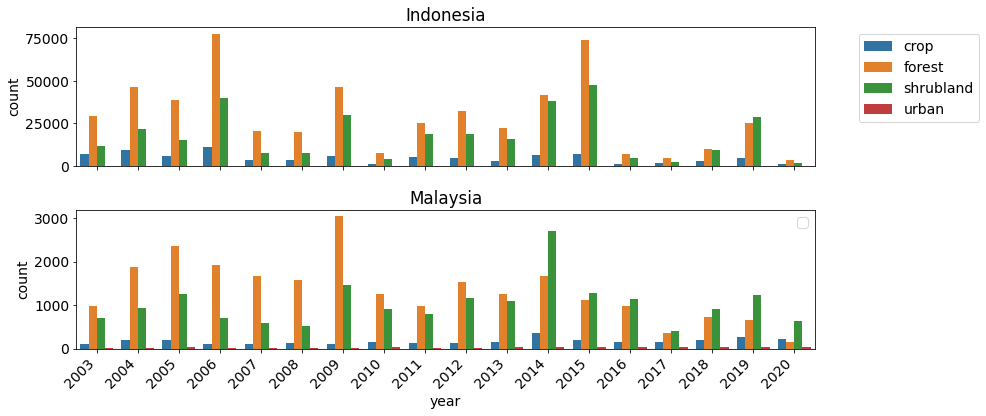

In [210]:
countries = ['Indonesia', 'Malaysia']
len(countries)

_, ax = plt.subplots(len(countries),1, figsize=(12, 3*len(countries)), sharex=True)

for i, (a, country) in enumerate(zip(ax, countries)):
    temp = lc_count[lc_count['country'] == country]
    sns.barplot(x="year", y="count", hue=prop_type, data=temp, ax=a)
    a.set_title(country)
    if i==0:
        a.legend(bbox_to_anchor=(1.05, 1))
    else:
        a.legend([])
        
    a.set_xlabel('')

a.set_xlabel('year')
a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right');
plt.tight_layout()
wmark_plt(fig)
plt.savefig(dataset.report_folder + 'landuse_country.png')

In [211]:
dataset.zone_list

[0, 100, 200, 400, 800, 1000]

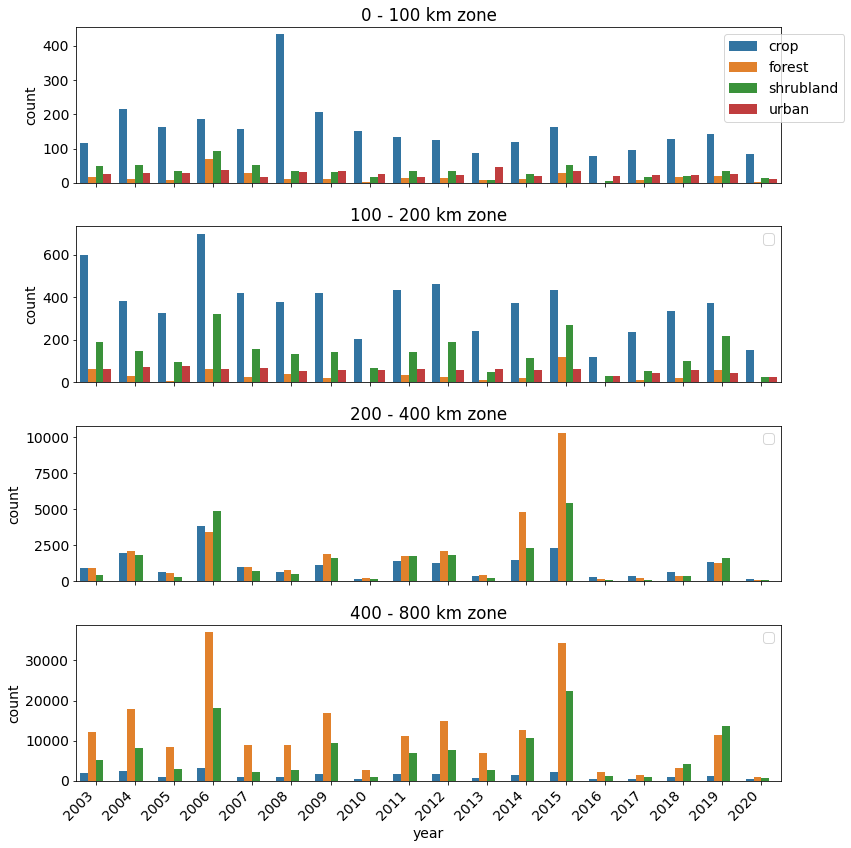

In [213]:
zone_list = dataset.zone_list[:5]
prop_type = 'LC_Type1_label'

_, ax = plt.subplots(len(zone_list[:-1]),1, figsize=(12, 3*len(zone_list[:-1])), sharex=True)


for i, (a, min_d, max_d) in enumerate(zip(ax, zone_list, zone_list[1:])):
    temp = fire[(fire['distance']< max_d) & (fire['distance'] >= min_d)]
    temp = temp.groupby(['year', prop_type], as_index=False)['count'].count()
    temp = temp[~temp[prop_type].isin(['water', 'unclassified'])]
    temp = temp[temp['year'] !=2002]
    
    sns.barplot(x="year", y="count", hue=prop_type, data=temp, ax=a)
    a.set_title(f'{min_d} - {max_d} km zone')
    if i==0:
        a.legend(bbox_to_anchor=(1.1, 1))
    else:
        a.legend([])
        
    a.set_xlabel('')

a.set_xlabel('year')
a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right');

plt.tight_layout()
wmark_plt(fig)
plt.savefig(dataset.report_folder + 'landuse_firezone.png')


## Repeating Patterns

In [214]:
# select fire in 600 km zone
max_distance = 800
subfire = fire[fire['distance'] <=max_distance]

In [215]:
subfire['count'] = 1
fire_no_nan = subfire[~subfire['country'].isna()]
country_list = fire_no_nan['country'].unique() 
country_list.sort()
# repeating hotspots  between year
repeat_out_year = []
repeat_list = [2, 4, 6, 8]
for country in country_list:
    s = cal_repeat_spots_ex_year(fire_no_nan[fire_no_nan['country']==country], repeat_list=repeat_list,accum=False)
    s.name = country 
    repeat_out_year.append(s)
    
repeat_out_year  =  pd.concat(repeat_out_year,axis=1)

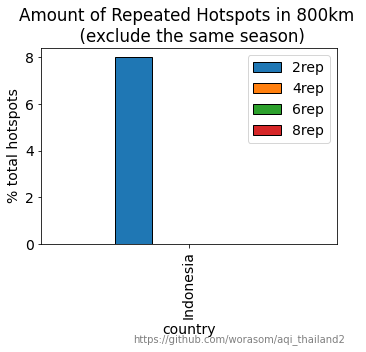

In [217]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = f'Amount of Repeated Hotspots in {max_distance}km \n (exclude the same season)'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')

ax.legend(['2rep', '4rep','6rep','8rep'])
wmark_plt(fig)
    
plt.tight_layout()

plt.savefig(dataset.report_folder + 'fire_repeat_no_accum.png')

In [222]:
subfire['count'] = 1
fire_no_nan = subfire[~subfire['country'].isna()]
country_list = fire_no_nan['country'].unique() 
country_list.sort()
# repeating hotspots  between year
repeat_out_year_accum = []
repeat_list = [4]
for country in country_list:
    s = cal_repeat_spots_ex_year(fire_no_nan[fire_no_nan['country']==country], repeat_list=repeat_list,accum=True)
    s.name = country 
    repeat_out_year_accum.append(s)
    
repeat_out_year_accum =   pd.concat(repeat_out_year_accum,axis=1)

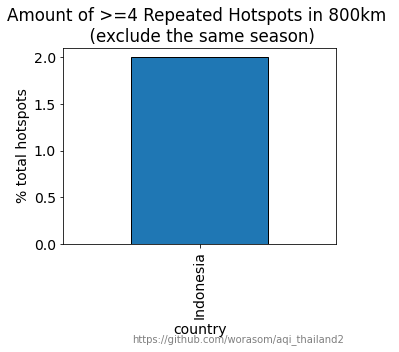

In [223]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year_accum.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = f'Amount of >=4 Repeated Hotspots in {max_distance}km \n (exclude the same season)'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')

wmark_plt(fig)
    
plt.tight_layout()
plt.savefig(dataset.report_folder + 'fire_repeat_accum.png')

# Pollution Colormap

In [226]:
# init dataset object and load
dataset = Dataset('Jakarta')
# use VIIRS to obtain a higher resolution hotspots
dataset.load_()
# extract the wind information 
wind = dataset.wea[['Wind', 'Wind_Speed(kmph)']]

In [227]:
# starting from init the map object
mapper = Mapper(report_folder = dataset.report_folder)
mapper.load_()

# add map setting to add center of the map
mapper.set_map_params(center_city='Jakarta')

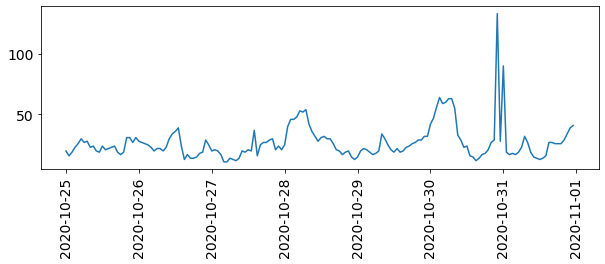

In [255]:
# Look for interesting date range
start_date = '2020-10-25'
end_date = '2020-10-31'
df = dataset.poll_df.loc[start_date:end_date]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df)
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [257]:
# extract pollution data during the date of interest
start_date = '2020-10-25'
end_date = '2020-10-31'
mapper.get_poll_by_daterange(start_date, end_date)
# take average pollution value of the city specified by mapper.center_city 
mapper.avg_city_poll()

In [258]:
# add pollutant of interest
mapper.pollutant = 'PM2.5'
# extract the pollution data 
mapper.get_datasamples(start_date, end_date, peak=True, freq=4) 


p1 = mapper.add_line_plot(title=f'{mapper.pollutant} level in {mapper.center_city}')
mapper.plot_datasample(p1)
show(p1)

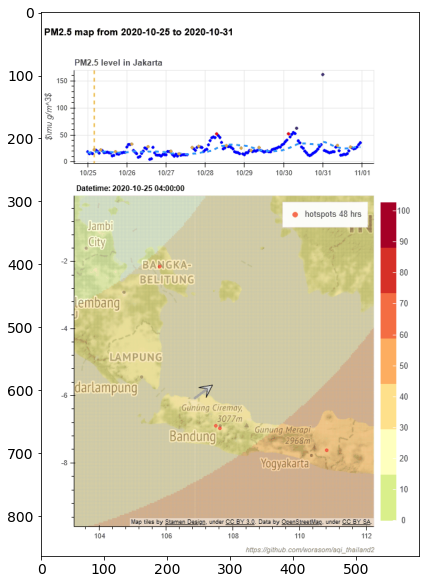

In [259]:
ani_filename = mapper.make_ani(start_date, end_date, pollutant='PM2.5', fire=dataset.fire, wind=wind)
img = mpimg.imread(ani_filename)

plt.figure(figsize=(10,10))
plt.imshow(img)